In [736]:
%matplotlib inline

In [737]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scipy.interpolate as interp
import matplotlib as mpl

## Test IMF pdf sampling for the full IMF (m = 0.01 - 120 Msun), with ~ m^(-0.5)

In [738]:
class imf(st.rv_continuous):
    def _pdf(self,x):
        return 1.0/(2*np.sqrt(120)-2*np.sqrt(0.01))*x**(-1./2)  # Normalized over its range, in this case [0.01,120]

my_imf_all = imf(a=0.01, b=120, name='imf')
sample_allmasses = np.asarray(my_imf_all.rvs(size=1000))

Text(0.5,1,'IMF ~ m^(-1/2)')

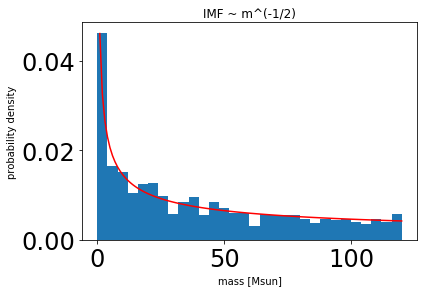

In [739]:
fig, ax = plt.subplots(1,1, figsize=[6,4])
n, bins, h = ax.hist(sample_allmasses, range = [0.01, 120], bins = 30, density = True)
x = np.linspace(1,120,120)
y = 1.0/(2*np.sqrt(120)-2*np.sqrt(0.01))*x**(-1./2)
ax.plot(x,y, 'r-')
ax.set_ylabel('probability density')
ax.set_xlabel('mass [Msun]')
ax.set_title('IMF ~ m^(-1/2)')

Now run IMF sampling for masses that are relevant for a Pal-5 like simple stellar population (age and metallicity), interpolate to CFHT MegaCam g-mag and stop when Ibata number of stars (1761?) between 20 < g < 23.


number of stars samples: 11728
IMF sampling luminosity function number of stars in 20 < g < 23: 1767


Text(0.5,1,'IMF ~ m^(-1/2)')

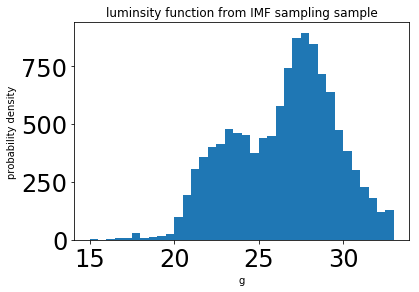

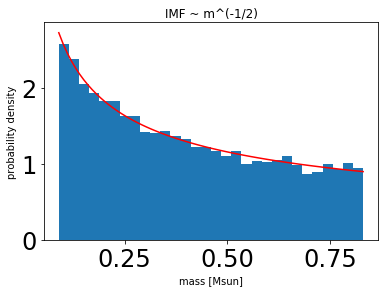

In [740]:
cfht_mini = np.loadtxt('Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
cfht_gmag = np.loadtxt('Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [24])
cfht_imag = np.loadtxt('Isochrone_CFHT_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [25])
wfirst_mini = np.loadtxt('Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [2])
wfirst_mags = np.loadtxt('Isochrone_WFIRST_PARSEC_withDust_newZ.txt', skiprows = 8, usecols = [23,24,25,26,27,28,29])

inter_gmags = interp.interp1d(cfht_mini, cfht_gmag)
inter_imags = interp.interp1d(cfht_mini, cfht_imag)
inter_Rmags = interp.interp1d(wfirst_mini, wfirst_mags[:,0])
inter_Zmags = interp.interp1d(wfirst_mini, wfirst_mags[:,1])
inter_Ymags = interp.interp1d(wfirst_mini, wfirst_mags[:,2])
inter_Jmags = interp.interp1d(wfirst_mini, wfirst_mags[:,3])
inter_Hmags = interp.interp1d(wfirst_mini, wfirst_mags[:,4])
inter_Fmags = interp.interp1d(wfirst_mini, wfirst_mags[:,5])
inter_Wmags = interp.interp1d(wfirst_mini, wfirst_mags[:,6])

## double check whether the minimum and maximum M_ini values are the same: True
#print np.max(cfht_mini), np.max(wfirst_mini), np.min(cfht_mini), np.min(wfirst_mini)


#sample from IMF sub-region renormalize to the right edges.
class imf_sub(st.rv_continuous):
    def _pdf(self,x):
        return 1.0/(2*np.sqrt(np.max(cfht_mini))-2*np.sqrt(np.min(cfht_mini)))*x**(-0.5)  # Normalized over its range, in this case [0.01,120]


my_imf_low = imf_sub(a=np.min(cfht_mini), b=np.max(cfht_mini), name='sub')
sample_lowmasses = []
tot_norm = 0


d_mod = 16.8553 ##distance modulus Pal5

while tot_norm < 1767:
    sample_lowmasses.append(my_imf_low.rvs(size=1))
    sample_gmags = inter_gmags(sample_lowmasses) + d_mod
    hist_gmag, bins_edges = np.histogram(sample_gmags, bins = 36, range = [15, 33])
    bins_gmag = (bins_edges[:-1] + bins_edges[1:])*0.5
    tot_norm = np.sum(hist_gmag[np.logical_and(bins_gmag < 23, bins_gmag > 20)])
    
print('number of stars samples: '+ str(len(sample_lowmasses)))
print('IMF sampling luminosity function number of stars in 20 < g < 23: '+ str(tot_norm))

fig, ax = plt.subplots(1,1, figsize=[6,4])
ax.set_ylabel('probability density')
ax.set_xlabel('g')
ax.set_title('luminsity function from IMF sampling sample')
h, be, p = ax.hist(sample_gmags, bins = 36, range = [15, 33])    

sample_lowmasses = np.asarray(sample_lowmasses)   
    
fig, ax = plt.subplots(1,1, figsize=[6,4])
n, bins, p = ax.hist(sample_lowmasses, range = [0.09, 0.83], bins = 30, density = True)
x = np.linspace(0.09,0.83,74)
y = 1.0/(2*np.sqrt(0.83)-2*np.sqrt(0.09))*x**(-1./2)
ax.plot(x,y, 'r-')
ax.set_ylabel('probability density')
ax.set_xlabel('mass [Msun]')
ax.set_title('IMF ~ m^(-1/2)')

Do initial mass - magnitude interpolation to get CFHT MegaCam g-mag, i-mag, and WFIRST mags luminosity function, for Pal-5 like age and metallicity simple stellar population

In [741]:
#np.linspace(10,35,100)

In [742]:
#mag_array = np.linspace(15,33,16)
#cum_stars = np.zeros(16)

In [743]:
wfirst_mags.shape

(237, 7)

In [744]:
wfirst_R = wfirst_mags[:,0]
wfirst_Z = wfirst_mags[:,1]

In [745]:
mag_array = np.linspace(10,35,100)
cum_stars_g = np.zeros(len(mag_array))
for i in range(len(mag_array)):
    no = len(np.where(sample_gmags < mag_array[i])[0])
   # print(no)
    cum_stars_g[i] = no



####Figure out how many stars to populate stream with:
#len(np.where((sample_gmags > 20) & (sample_gmags < 23) )[0]) should be 1767
nstars_pandas = len(np.where((sample_gmags < 25.5 - 7.6))[0])
nstars_pandas_m10 = nstars_pandas * 10

In [746]:
#len(sample_gmags)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3449: UserWarning: Attempted to set non-positive ylimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive ylimits for log-scale axis; '


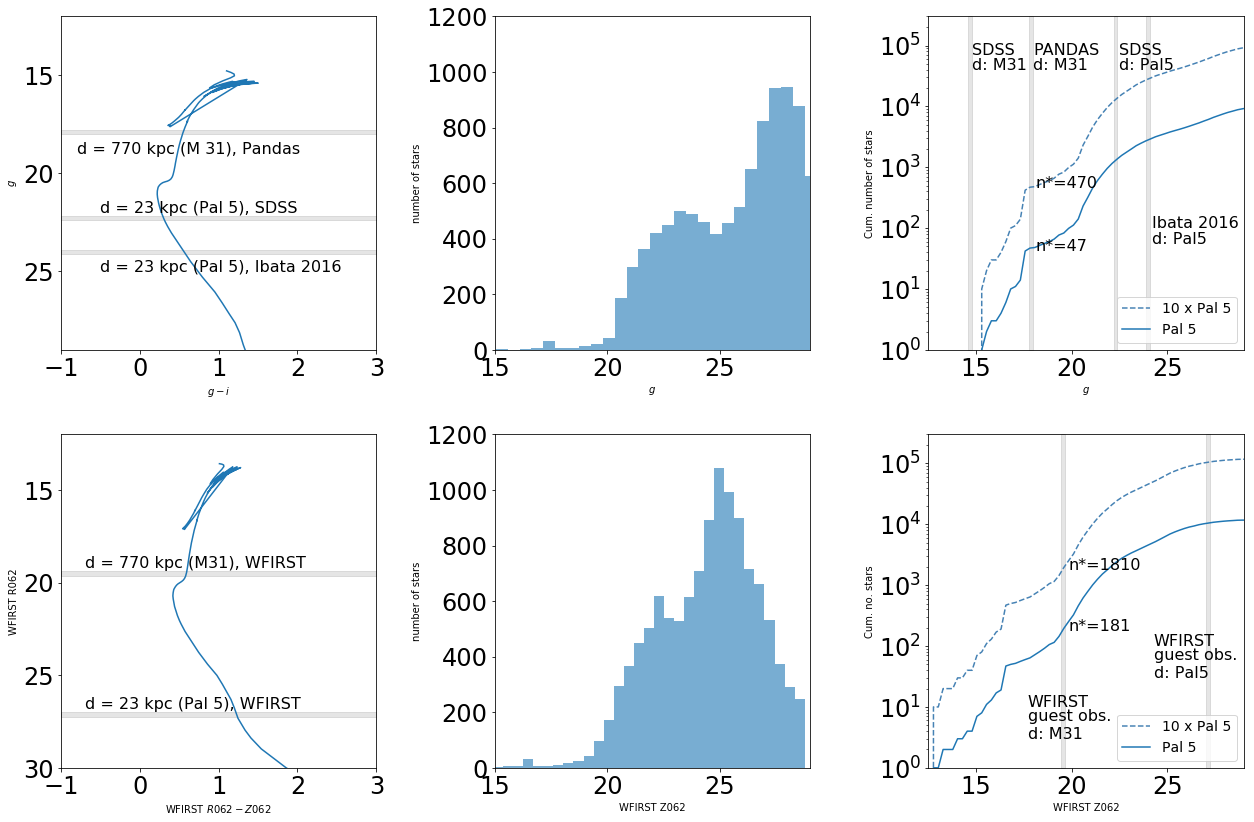

In [747]:

fig, ax = plt.subplots(2,3, figsize=[18,12])
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

ax[0,0].plot(cfht_gmag[:-1] - cfht_imag[:-1], cfht_gmag[:-1] + d_mod)
ax[0,0].set_ylim([29,12])
#ax[0].set_title('Isochrone from PARSEC')
ax[0,0].set_xlim([-1,3])
ax[0,0].fill_between([-1,4],25.4-7.6,25.6-7.6,color='black', alpha=0.1)
ax[0,0].text(-0.8,26.6-7.6, 'd = 770 kpc (M 31), Pandas', fontsize=16)

ax[0,0].fill_between([-1,4],23.9,24.1,color='black', alpha=0.1)
ax[0,0].text(-0.5,25, 'd = 23 kpc (Pal 5), Ibata 2016', fontsize=16)
ax[0,0].fill_between([-1,4],22.2,22.4,color='black', alpha=0.1)
ax[0,0].text(-0.5,22.0, 'd = 23 kpc (Pal 5), SDSS', fontsize=16)
ax[0,0].set_ylabel('$g$')
ax[0,0].set_xlabel('$g-i$')

ax[0,1].set_ylabel('number of stars')
ax[0,1].set_xlabel('$g$')
#ax[1].set_title('luminsity function from IMF sampling')
ax[0,1].set_xlim([15,29])
ax[0,1].set_ylim([0,1200])
h, be, p = ax[0,1].hist(sample_gmags, bins = 36, range = [14, 33], alpha=0.6) 


ax[0,2].plot(mag_array, cum_stars_g*10, color='steelblue',linestyle='--', label='10 x Pal 5')
ax[0,2].plot(mag_array, cum_stars_g, label='Pal 5')
#ax[2].plot(mag_array + 7.6, cum_stars_g)
ax[0,2].set_yscale('log')
ax[0,2].set_xlabel('$g$')
#ax[2].set_title("At Pal5's distance")
ax[0,2].set_ylabel('Cum. number of stars')
ax[0,2].fill_between([23.9,24.1],1,300000,color='black', alpha=0.1)
ax[0,2].text(24.2,10**2, 'Ibata 2016', fontsize=16)
ax[0,2].text(24.2,5.5*10, 'd: Pal5', fontsize=16)
###axes[2].axhline(24, color = 'mediumpurple', linestyle='-.', label="CFHT, Ibata 2016")
ax[0,2].fill_between([22.2,22.4],1,300000,color='black', alpha=0.1)
ax[0,2].text(22.5,7*10**4, 'SDSS', fontsize=16)
ax[0,2].text(22.5,4*10**4, 'd: Pal5', fontsize=16)
ax[0,2].fill_between([25.4-7.6,25.6-7.6],1,300000,color='black', alpha=0.1)
ax[0,2].text(25.6-7.6,7*10**4, 'PANDAS', fontsize=16)
ax[0,2].text(25.6-7.6,4*10**4, 'd: M31', fontsize=16)
ax[0,2].text(22.4-7.6,7*10**4, 'SDSS', fontsize=16)
ax[0,2].text(22.4-7.6,4*10**4, 'd: M31', fontsize=16)
ax[0,2].fill_between([22.2-7.6,22.4-7.6],1,300000,color='black', alpha=0.1)

ax[0,2].text(25.7-7.6,nstars_pandas-4, 'n*=' + str(nstars_pandas), fontsize=16)
ax[0,2].text(25.7-7.6,nstars_pandas_m10-4, 'n*=' + str(nstars_pandas_m10), fontsize=16)

ax[0,2].set_ylim([0,300000])
ax[0,2].set_xlim([12.5,29])
ax[0,2].legend(fontsize=14, loc='lower right')

# ax[1,1].plot(mag_array + 7.6, cum_stars_g)
# ax[1,1].set_yscale('log')
# ax[1,1].set_xlabel('$g$ mag')
# ax[1,1].set_title("At M31's distance")
# ax[1,1].set_ylabel('Cum. number of stars')
# ax[1,1].fill_between([25.4,25.6],1,30000,color='steelblue', alpha=0.3)
# ax[1,1].text(25.6,10**3, 'PANDAS', fontsize=14)
# ax[1,1].fill_between([22.2,22.4],1,30000,color='steelblue', alpha=0.3)
# ax[1,1].text(22.4,10**3, 'SDSS', fontsize=14)
# ax[1,1].set_ylim([0,30000])


if np.sum(sample_lowmasses < np.min(cfht_mini)) > 0 or np.sum(sample_lowmasses > np.max(cfht_mini)) > 0:
    print("outside of interpolation range based on the CFHT-parsec SSP file. Need to resolve this.")
else:    
    #CFHT magnitudes
    sample_gmags = inter_gmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_imags = inter_imags(sample_lowmasses) + d_mod #distance modulus Pal5
    #WFIRST magnitudes
    sample_Rmags = inter_Rmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Zmags = inter_Zmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Ymags = inter_Ymags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Jmags = inter_Jmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Hmags = inter_Hmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Fmags = inter_Fmags(sample_lowmasses) + d_mod #distance modulus Pal5
    sample_Wmags = inter_Wmags(sample_lowmasses) + d_mod #distance modulus Pal5
    
    ### SUM up histogram ###

    mag_array = np.linspace(10,35,100)
    cum_stars_R = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Rmags < mag_array[i])[0])
        #print(no)
        cum_stars_R[i] = no

    mag_array = np.linspace(10,35,100)
    cum_stars_Z = np.zeros(len(mag_array))
    for i in range(len(mag_array)):
        no = len(np.where(sample_Zmags < mag_array[i])[0])
        #print(no)
        cum_stars_Z[i] = no

    nstars_wfirst = len(np.where((sample_Zmags < 27.15-7.6))[0])
    nstars_wfirst_m10 = nstars_wfirst * 10
 

    ax[1,0].plot(wfirst_R[:-1] - wfirst_Z[:-1], wfirst_R[:-1] + d_mod)
    ax[1,0].set_ylim([30,12])
   # ax[0].set_title('Isochrone from PARSEC')
    ax[1,0].fill_between([-1,4],27.0-7.6,27.25-7.6,color='black', alpha=0.1)
    ax[1,0].text(-0.7,26.8-7.6, 'd = 770 kpc (M31), WFIRST', fontsize=16)
    ax[1,0].fill_between([-1,4],27.0,27.25,color='black', alpha=0.1)
    ax[1,0].text(-0.7,26.8, 'd = 23 kpc (Pal 5), WFIRST', fontsize=16)
    ax[1,0].set_xlim([-1,3])
    ax[1,0].set_ylabel('WFIRST R062')
    ax[1,0].set_xlabel('WFIRST $R062 - Z062$')

    ax[1,1].set_ylabel('number of stars')
    ax[1,1].set_xlabel('WFIRST Z062')
  #  ax[1].set_title('luminsity function from IMF sampling')
    ax[1,1].set_xlim([15,29])
    ax[1,1].set_ylim([0,1200])
    h, be, p = ax[1,1].hist(sample_Zmags, bins = 36, alpha=0.6)

    ax[1,2].plot(mag_array, cum_stars_Z*10, color='steelblue',linestyle='--',label='10 x Pal 5')
    ax[1,2].plot(mag_array, cum_stars_Z,label= 'Pal 5')
    #ax[2].set_title("At Pal5's distance")
    ax[1,2].set_yscale('log')
    ax[1,2].set_xlabel('WFIRST Z062')
    ax[1,2].fill_between([27.05,27.25],1,300000,color='black', alpha=0.1)
    ax[1,2].text(24.3,10**2, 'WFIRST', fontsize=16)
    ax[1,2].text(24.3,6*10**1, 'guest obs.', fontsize=16)
    ax[1,2].text(24.3,3*10**1, 'd: Pal5', fontsize=16)
    ax[1,2].fill_between([27.05-7.6,27.25-7.6],1,300000,color='black', alpha=0.1)
    ax[1,2].text(25.3-7.6,10**1, 'WFIRST', fontsize=16)
    ax[1,2].text(25.3-7.6,6*10**0, 'guest obs.', fontsize=16)
    ax[1,2].text(25.3-7.6,3*10**0, 'd: M31', fontsize=16)
    ax[1,2].set_ylabel('Cum. no. stars')
    
    ax[1,2].text(27.45-7.6,nstars_wfirst-4, 'n*=' + str(nstars_wfirst), fontsize=16)
    ax[1,2].text(27.45-7.6,nstars_wfirst_m10-4, 'n*=' + str(nstars_wfirst_m10), fontsize=16)
    
    ax[1,2].set_ylim([0,300000])
    ax[1,2].set_xlim([12.5,29])
    ax[1,2].legend(fontsize=14, loc='lower right')


#     ax[1,1].plot(mag_array+7.6, cum_stars_Z)
#     ax[1,1].plot(mag_array+7.6, cum_stars_Z*10, color='steelblue',linestyle='--')
#     ax[1,1].set_yscale('log')
#     ax[1,1].set_xlabel('WFIRST Z062')
#     ax[1,1].set_title("At M31's distance")
#     ax[1,1].set_ylabel('Cum. no. stars')
#     ax[1,1].fill_between([27.05,27.25],1,300000,color='steelblue', alpha=0.3)
#     ax[1,1].text(25.6,10**3, 'WFIRST, guest obs.', fontsize=14)
#     ax[1,1].set_ylim([0,300000])
    fig.tight_layout()
    fig.savefig('FIG1_CFHT_WFIRST.pdf',  rasterized=True)
#G-band limiting mag: 25.5 with S/N=10 
#https://www.noao.edu/meetings/m31/files/Martin_PAndAS.pdf
#PUT SDSS and PANDAS limits on (same g-band) 
    
    
    
    
    
    
    


#G-band limiting mag: 25.5 with S/N=10 
#https://www.noao.edu/meetings/m31/files/Martin_PAndAS.pdf
#PUT SDSS and PANDAS limits on (same g-band) 

In [748]:
#len(cfht_imag)


In [749]:
nstars_pandas

47

In [750]:
#np.linspace(1,200,200)

In [946]:
##WFIRST can see to a limiting Z mag of 27.15 with guest observer program

#10 Mpc is a factor of 435 farther than Pal 5 
#andromeda is a factor of 33 farther in diustanc 
#make dfac into array

#dfac = np.array([1,5,10,15,33,40,50,60,70,80,100,120,150])#,200])#,435]) #use these for the no. stars per distance plot 

dfac = np.linspace(1,400,1000)

#dfac = 33#435#33#andr # factor you move distance farther out by
d_pal5 = 23500 # kpc
mod_pal5 = 5*np.log10(d_pal5/10)
mag_fac = np.zeros(len(dfac))
for i in range(len(dfac)):
    mod =  5*np.log10(d_pal5 * dfac[i]/10)
    mag_fac[i] = mod - mod_pal5
    
#print(mag_fac)


#mag_array
#cum_stars_Z

In [947]:
#print(mag_array+7.6)
#print(cum_stars_Z)

In [948]:
# mag_ind = np.where((mag_array + mag_fac[6] > 26.9) & (mag_array + mag_fac[6] < 27.3))
# #print(mag_array + mag_fac[6])
# #print(mag_ind )
# cum_stars_Z[mag_ind]

In [949]:

no_stars = np.zeros(len(dfac))
for i in range(len(dfac)):
    mag_ind = np.where((mag_array + mag_fac[i] > 26.9) & (mag_array + mag_fac[i] < 27.3))
 #   print(mag_ind[0][0])
 #   print(cum_stars_Z[mag_ind[0][0]])
    no_stars[i] = cum_stars_Z[mag_ind[0][0]]
    
#no_stars

In [950]:
#More massive Pal 5 

dfac_m10 = np.linspace(1,400,1000)
no_stars_m10 = np.zeros(len(dfac_m10))
for i in range(len(dfac_m10)):
    mag_ind = np.where((mag_array + mag_fac[i] > 26.9) & (mag_array + mag_fac[i] < 27.3))
 #   print(mag_ind[0][0])
 #   print(cum_stars_Z[mag_ind[0][0]])
    no_stars_m10[i] = cum_stars_Z[mag_ind[0][0]]
    
#no_stars

In [951]:
distance = np.arange(0,10,0.1)
Pal5_stars_wfirst = np.linspace(20,0,100)
Pal5_x10_stars_wfirst =np.linspace(200,0,100)

In [900]:
#dfac*d_pal5/1000
dfac_m10.shape

(100,)

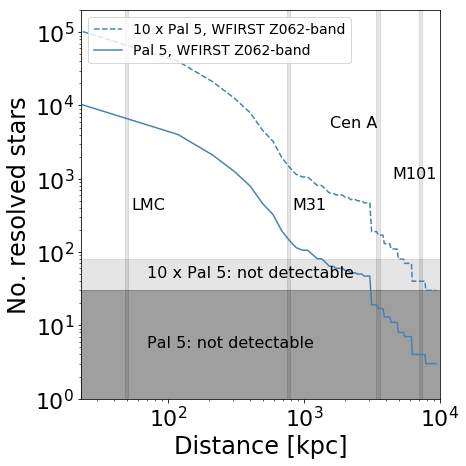

In [903]:

fig,axes = plt.subplots(1,1,figsize=(7,7))

mpl.rcParams.update({'font.size': 24})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


#axes.plot(distance ,Pal5_x10_stars_wfirst ,label='10 x Pal 5', color='maroon', linestyle='--')
#axes.plot(distance ,Pal5_stars_wfirst ,label='Pal 5', color = 'maroon')
axes.plot(dfac_m10 * d_pal5/1000 , no_stars*10, label='10 x Pal 5, WFIRST Z062-band', linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

axes.plot(dfac * d_pal5/1000 , no_stars, label='Pal 5, WFIRST Z062-band', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

#axes.set_title('FeH = all, R$_{gc}$ = 10kpc')
axes.set_xlabel('Distance [kpc]')
axes.fill_between([48,51],0,1000000,color='black', alpha=0.1)
axes.text(54,380, 'LMC', fontsize=16,color='black')
axes.fill_between([755,785],0,1000000,color='black', alpha=0.1)
axes.text(820,380, 'M31', fontsize=16,color='black')
axes.fill_between([3400,3600],0,1000000,color='black', alpha=0.1)
axes.text(1550, 5000, 'Cen A', fontsize=16,color='black')
axes.fill_between([7000,7360],0,1000000,color='black', alpha=0.1)
axes.text(4500, 1000, 'M101', fontsize=16,color='black')


axes.fill_between([0,10060],0,80,color='black', alpha=0.1)
axes.text(70, 45, '10 x Pal 5: not detectable', color='black',fontsize=16)
axes.fill_between([0,10060],0,30,color='black', alpha=0.3)
axes.text(70, 5, 'Pal 5: not detectable', color='black',fontsize=16)
axes.set_ylabel('No. resolved stars')
axes.set_xlim([23,10000])
axes.set_yscale('log')
axes.set_xscale('log')
axes.set_ylim([1,200000])
axes.legend(fontsize=14, loc=('upper left'))
fig.tight_layout()


fig.savefig('Fig4_Distance.pdf',  rasterized=True)

In [759]:
d_mod_pal5 = 5*np.log10(23500/10) 

## Recalculate length and widht of streams

I assume the following initial params for Pal 5:

Length = 8.5 kpc,
Width= 0.058 kpc


In [760]:
pal5_width = 0.058 #kpc
pal5_length = 8.5 #kpc

## V$_{circ}$ correction

In [761]:
#### Correct for Andromeda tides ####
v_circ_MW = 220 #km/s
v_circ_M31 = 250 #km/s Chemin et al 2009 HI emission
v_corr =  (1/(250/220)**(2/3.)) #r_t smaller as the tidal field from M31 is larger 

# This should go into both length and width (their smaller)

## Mass correction

In [762]:
### Correct for mass of cluster ####
m_corr = (10)**(1/3.)

#The more massive stream should be longer and wider by this factor

## R$_{GC}$ and T$_{\psi}$ corrections

In [763]:
##### Correct for various locations in Galaxy
R_p = np.array([15,35,55]) # kpc we use these three different R_GCs

Rp_corr = np.zeros(len(R_p))
for i in range(len(R_p)):
    Rp_corr[i] = (R_p[i]/R_p[0])**(2/3.) #gets longer and wider width distance 

### Correct for the fact that T_psi changes (less completed orbits)
##THIS IS THE ANGULAR EXTENT
psi_corr  = np.zeros(len(R_p))
for i in range(len(R_p)):
    psi_corr[i] = (R_p[0]/R_p[i]) #angular length gets smaller.


## For surface brightness calculations

In [764]:
# Pal 5 like stream:

#### R_GC = 15 kpc ####
print('m: Pal5')
print('R_GC = 15 kpc')
w_15 = pal5_width * v_corr * Rp_corr[0] 
l_15 = pal5_length * v_corr * Rp_corr[0] #* psi_corr[0]
print('w = ' +  str(np.round(w_15,3)) + ' kpc')
print('')

#### R_GC = 35 kpc ####
print('R_GC = 35 kpc')
w_35 = pal5_width * v_corr * Rp_corr[1] 
l_35 = pal5_length * v_corr * Rp_corr[1] #* psi_corr[1]
print('w = ' +  str(np.round(w_35,3)) + ' kpc')
print('')

#### R_GC = 55 kpc ####
print('R_GC = 55 kpc')
w_55 = pal5_width * v_corr * Rp_corr[2] 
l_55 = pal5_length * v_corr * Rp_corr[2] 
print('w = ' +  str(np.round(w_55,3)) + ' kpc')
print('')

print('')
print('')
# Pal 5 like stream:

#### R_GC = 15 kpc ####
print('m:10 x Pal5') 
print('R_GC = 15 kpc')
w = pal5_width * m_corr * v_corr * Rp_corr[0] 
l = pal5_length * m_corr * v_corr * Rp_corr[0] #* psi_corr[0]
print('w = ' +  str(np.round(w,3)) + ' kpc')
print('')

#### R_GC = 35 kpc ####
print('R_GC = 35 kpc')
w = pal5_width * m_corr * v_corr * Rp_corr[1] 
l = pal5_length * m_corr * v_corr * Rp_corr[1] #* psi_corr[1]
print('w = ' +  str(np.round(w,3)) + ' kpc')
print('')

#### R_GC = 55 kpc ####
print('R_GC = 55 kpc')
w = pal5_width * m_corr* v_corr * Rp_corr[2] 
l = pal5_length * m_corr * v_corr * Rp_corr[2] 
print('w = ' +  str(np.round(w,3)) + ' kpc')
print('')

m: Pal5
R_GC = 15 kpc
w = 0.053 kpc

R_GC = 35 kpc
w = 0.094 kpc

R_GC = 55 kpc
w = 0.127 kpc



m:10 x Pal5
R_GC = 15 kpc
w = 0.115 kpc

R_GC = 35 kpc
w = 0.202 kpc

R_GC = 55 kpc
w = 0.273 kpc



In [765]:
# #Because I am computing arcs of circle based on angles:
# circumfr = 2*np.pi*R_p
# # At R_p = 15 kpc, we want the stream to be 7.81 kpc in Andromeda, 
# #so I need to figure out what fraction of the circumfrence this corresponds to
# #this fraction is ------- 1/11.08 ------
# lengths_kpc = np.array([7.81,13.73, 18.56]) # Without correcting for angle (T_psi)
# lengths_kpc_m10 = lengths_kpc  * m_corr

# #Now we correct for angle! Meaning a factor of R_p less in angular extent. 
# lengths_kpc_ang = np.array([l_15 /(R_p[0]/R_p[0]),\
#                             l_35/(R_p[1]/R_p[0]),\
#                             l_55/(R_p[2]/R_p[0])])# Without correcting for angle (T_psi)
# lengths_kpc_m10_ang = lengths_kpc_ang * m_corr
# print('Lengths for pal-5like stream at 3 radii: ')
# print(lengths_kpc_ang)
# print('')
# print('Lengths for 10x mass stream at 3 radii: ')
# print(lengths_kpc_m10_ang)
# print('')


# print('sanity check for circle arc plotting')
# circ_corr = np.array([12.065,37.37,68.28]) #just to get from full circle down to 7.81 kpc
# print(circumfr / circ_corr) #Only doing this because I am plotting as a fraction of a circle

# #Do it for more massive stream to
# print(circumfr / circ_corr*m_corr) #Only doing this because I am plotting as a fraction of a circle
# #lengths_kpc 


In [766]:
######### NEW LENGTH CALC ####### 02/25/19
#Because I am computing arcs of circle based on angles:
circumfr = 2*np.pi*R_p

v_corr_L = (250/220)**(1/3.)


lengths_kpc = np.array([8.5,8.5, 8.5])*v_corr_L
lengths_kpc_m10 = lengths_kpc  * m_corr

#Now we correct for angle! Meaning a factor of R_p less in angular extent. 
lengths_kpc_ang = np.array([l_15 *(R_p[0]/R_p[0])**(-1/3),\
                            l_35*(R_p[1]/R_p[0])**(-1/3),\
                            l_55*(R_p[2]/R_p[0])**(-1/3)])# Without correcting for angle (T_psi)
lengths_kpc_m10_ang = lengths_kpc_ang * m_corr
print('Lengths for pal-5like stream at 3 radii: ')
print(lengths_kpc_ang)
print('')
print('Lengths for 10x mass stream at 3 radii: ')
print(lengths_kpc_m10_ang)
print('')


print('sanity check for circle arc plotting')
circ_corr = np.array([12.0755,21.24,28.7]) #just to get from full circle down to 7.81 kpc
print(circumfr / circ_corr) #Only doing this because I am plotting as a fraction of a circle

#Do it for more massive stream to
print(circumfr / circ_corr*m_corr) #Only doing this because I am plotting as a fraction of a circle
#lengths_kpc 


Lengths for pal-5like stream at 3 radii: 
[ 7.80561944 10.3530021  12.03643433]

Lengths for 10x mass stream at 3 radii: 
[16.81669731 22.30486688 25.93171166]

sanity check for circle arc plotting
[ 7.80487596 10.35364811 12.04094745]
[16.81509551 22.30625865 25.94143489]


In [767]:
pal5_width = 0.058 #kpc
pal5_length = 8.5 #kpc

In [768]:
#Calculating areas:
    
    #pal5 like
A15 = 0.053 *  7.80561944 #kpc^2
A35 = 0.094 * 10.3530021
A55 = 0.127 *  12.0364343

#10 x pal 5 like
A15_m10 = 0.115 * 16.81669731
A35_m10 = 0.202 * 22.30486688
A55_m10 = 0.273 * 25.93171166

print('Pal 5 like at 15 kpc')
print(str(A15)+' [kpc^2]')
print('')
print('Pal 5 like at 35 kpc')
print(str(A35)+' [kpc^2]')
print('')
print('Pal 5 like at 55 kpc')
print(str(A55)+' [kpc^2]')
print('')
print('')
print('10 x Pal 5 like at 15 kpc')
print(str(A15_m10)+' [kpc^2]')
print('')
print('10 x Pal 5 like at 35 kpc')
print(str(A35_m10)+' [kpc^2]')
print('')
print('10 x Pal 5 like at 55 kpc')
print(str(A55_m10)+' [kpc^2]')

Pal 5 like at 15 kpc
0.41369783032 [kpc^2]

Pal 5 like at 35 kpc
0.9731821974 [kpc^2]

Pal 5 like at 55 kpc
1.5286271561 [kpc^2]


10 x Pal 5 like at 15 kpc
1.9339201906499999 [kpc^2]

10 x Pal 5 like at 35 kpc
4.50558310976 [kpc^2]

10 x Pal 5 like at 55 kpc
7.079357283180001 [kpc^2]


In [769]:
import astropy.units as u


###### First correct them all by the fraction to make it right length at R=15 kpc

#I divide 360 by fac to make it 7.81
theta1 = np.array([(90-360/circ_corr[0])*u.deg.to(u.rad),    \
                   (90-360/circ_corr[1])*u.deg.to(u.rad),\
                   (90-360/circ_corr[2])*u.deg.to(u.rad)])  
#sets length of streams, should vary for each 

theta2 = np.array([90*u.deg.to(u.rad),90*u.deg.to(u.rad),90*u.deg.to(u.rad)])


theta1_m10 = np.array([(90-360/circ_corr[0]*m_corr)*u.deg.to(u.rad),    \
                   (90-360/circ_corr[1]*m_corr)*u.deg.to(u.rad),\
                   (90-360/circ_corr[2]*m_corr)*u.deg.to(u.rad)])  
#sets length of streams, should vary for each 

theta2_m10 = np.array([90*u.deg.to(u.rad),90*u.deg.to(u.rad),90*u.deg.to(u.rad)])

## Construct Pal 5 like stream

In [770]:
num_samples = nstars_pandas #this is the amount of stars 

theta = np.zeros([num_samples,len(R_p)])
for i in range(theta.shape[1]):
    theta[:,i] = np.random.uniform(theta1[i], theta2[i], num_samples)#*rand_dist_angle #spread out circle 
#theta = np.linspace(theta1, theta2, num_samples)

#Here I correct width for v_corr
rand_dist_width = np.random.uniform(-pal5_width/2*v_corr, pal5_width/2*v_corr, num_samples) #such that they are rand. spread in angle 
#I have three different distances , r array


#Here I correct width for Rp
dr = np.zeros([num_samples,len(R_p)])
for i in range(dr.shape[1]):
    dr[:,i] = 1 * rand_dist_width * Rp_corr[i] 
    #scale such that width gets udpated based on post in galacy


r_rand = np.ones([num_samples,len(R_p)])*R_p + dr   #R_p here puts the streams at 3 GC radii
x,y = r_rand * np.cos(theta), r_rand * np.sin(theta)

In [771]:
nstars_pandas_m10

470

## Construct massive stream

In [772]:
num_samples_m10 = nstars_pandas_m10 #this is the amount of stars 

theta = np.zeros([num_samples_m10,len(R_p)])
for i in range(theta.shape[1]):
    theta[:,i] = np.random.uniform(theta1_m10[i], theta2_m10[i], num_samples_m10)#*rand_dist_angle #spread out circle 
#theta = np.linspace(theta1, theta2, num_samples)

#Here I correct width for v_corr
rand_dist_width = np.random.uniform(-pal5_width/2*v_corr * m_corr, \
                                    pal5_width/2*v_corr * m_corr, num_samples_m10) #such that they are rand. spread in angle 
#I have three different distances , r array


#Here I correct width for Rp
dr = np.zeros([num_samples_m10,len(R_p)])
for i in range(dr.shape[1]):
    dr[:,i] = 1 * rand_dist_width * Rp_corr[i] 
    #scale such that width gets udpated based on post in galacy

    
#Here I correct length for Rp_corr    
r_rand = np.ones([num_samples_m10,len(R_p)])*R_p + dr   #R_p here puts the streams at 3 GC radii
x_m10,y_m10 = r_rand * np.cos(theta), r_rand * np.sin(theta)

In [773]:
pal5_x_GC15 = x[:,0]
pal5_x_GC35 = x[:,1]
pal5_x_GC55 = x[:,2]

pal5_y_GC15 = y[:,0]
pal5_y_GC35 = y[:,1]
pal5_y_GC55 = y[:,2]



pal5_x_m10_GC15 = x_m10[:,0]
pal5_x_m10_GC35 = x_m10[:,1]
pal5_x_m10_GC55 = x_m10[:,2]

pal5_y_m10_GC15 = y_m10[:,0]
pal5_y_m10_GC35 = y_m10[:,1]
pal5_y_m10_GC55 = y_m10[:,2]

## Plot streams

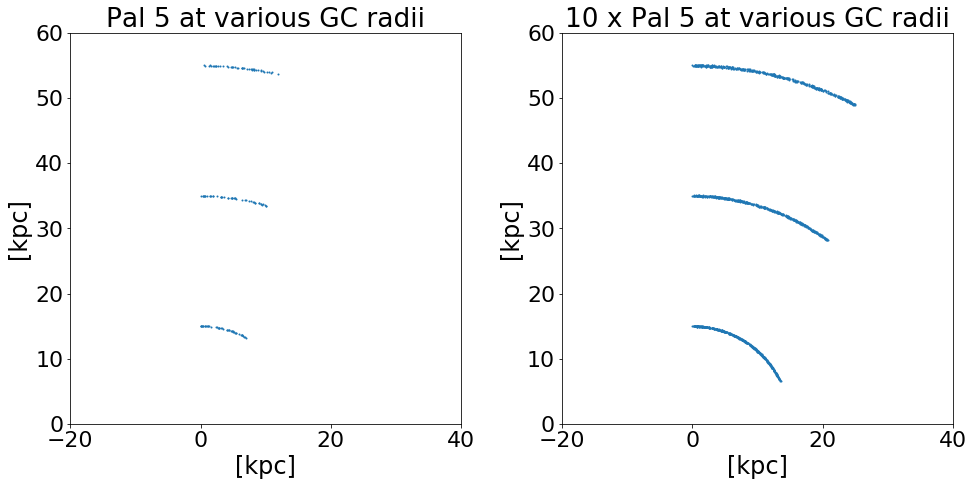

In [774]:
fig,axes = plt.subplots(1,2,figsize=(14,7))
#SEE https://matplotlib.org/api/_as_gen/matplotlib.patches.Arc.html
mpl.rcParams.update({'font.size': 22})
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 


axes[0].scatter(x,y, s=1)
axes[0].set_ylim([0,60])
axes[0].set_xlim([-20,40])
axes[0].set_xlabel('[kpc]')
axes[0].set_ylabel('[kpc]')
axes[0].set_title('Pal 5 at various GC radii')
axes[0].set_aspect('equal')


axes[1].scatter(x_m10,y_m10, s=1)
axes[1].set_ylim([0,60])
axes[1].set_xlim([-20,40])
axes[1].set_xlabel('[kpc]')
axes[1].set_ylabel('[kpc]')
axes[1].set_title('10 x Pal 5 at various GC radii')
axes[1].set_aspect('equal')

fig.tight_layout()
#fig.savefig("GreatCircles_angular_R23rds.png")
###IMPORTANT SOME OF THESE AR CLUSTER STARS?? - no they're not! 


##### DO THIS FOR OTHER BAND!!######

## Now loading M31 PANDAS fields to see if we can detect streams

In [775]:
from astropy.io.votable import parse_single_table
table_box10 = parse_single_table("/Users/spearson/Desktop/Research/Pal5External/M31_10_20kpc_new.vot").to_table()
table_box30 = parse_single_table("/Users/spearson/Desktop/Research/Pal5External/M31_30_40kpc_new.vot").to_table()
table_box50 = parse_single_table("/Users/spearson/Desktop/Research/Pal5External/M31_50_60kpc_new.vot").to_table()

In [776]:
#table_box10

In [777]:
d_conv = 770*np.pi/180 #To go from deg to kpc in Andromeda


x_box10 = table_box10['xki']*(-d_conv)
y_box10 = table_box10['eta']*(d_conv)
g_box10 = table_box10['g']
i_box10 = table_box10['i']

x_box30 = table_box30['xki']*(-d_conv)
y_box30 = table_box30['eta']*(d_conv)
g_box30 = table_box30['g']
i_box30 = table_box30['i']

x_box50 = table_box50['xki']*(-d_conv)
y_box50 = table_box50['eta']*(d_conv)
g_box50 = table_box50['g']
i_box50 = table_box50['i']



In [778]:
#x_box10

In [779]:
### Make metallicity cuts

index_FeH0_10 = np.where(table_box10['FeH_phot'] < 0)
index_FeH0_30 = np.where(table_box30['FeH_phot'] < 0)
index_FeH0_50 = np.where(table_box50['FeH_phot'] < 0)

index_FeH1_10 = np.where(table_box10['FeH_phot'] < -1.3)
index_FeH1_30 = np.where(table_box30['FeH_phot'] < -1.3)
index_FeH1_50 = np.where(table_box50['FeH_phot'] < -1.3)

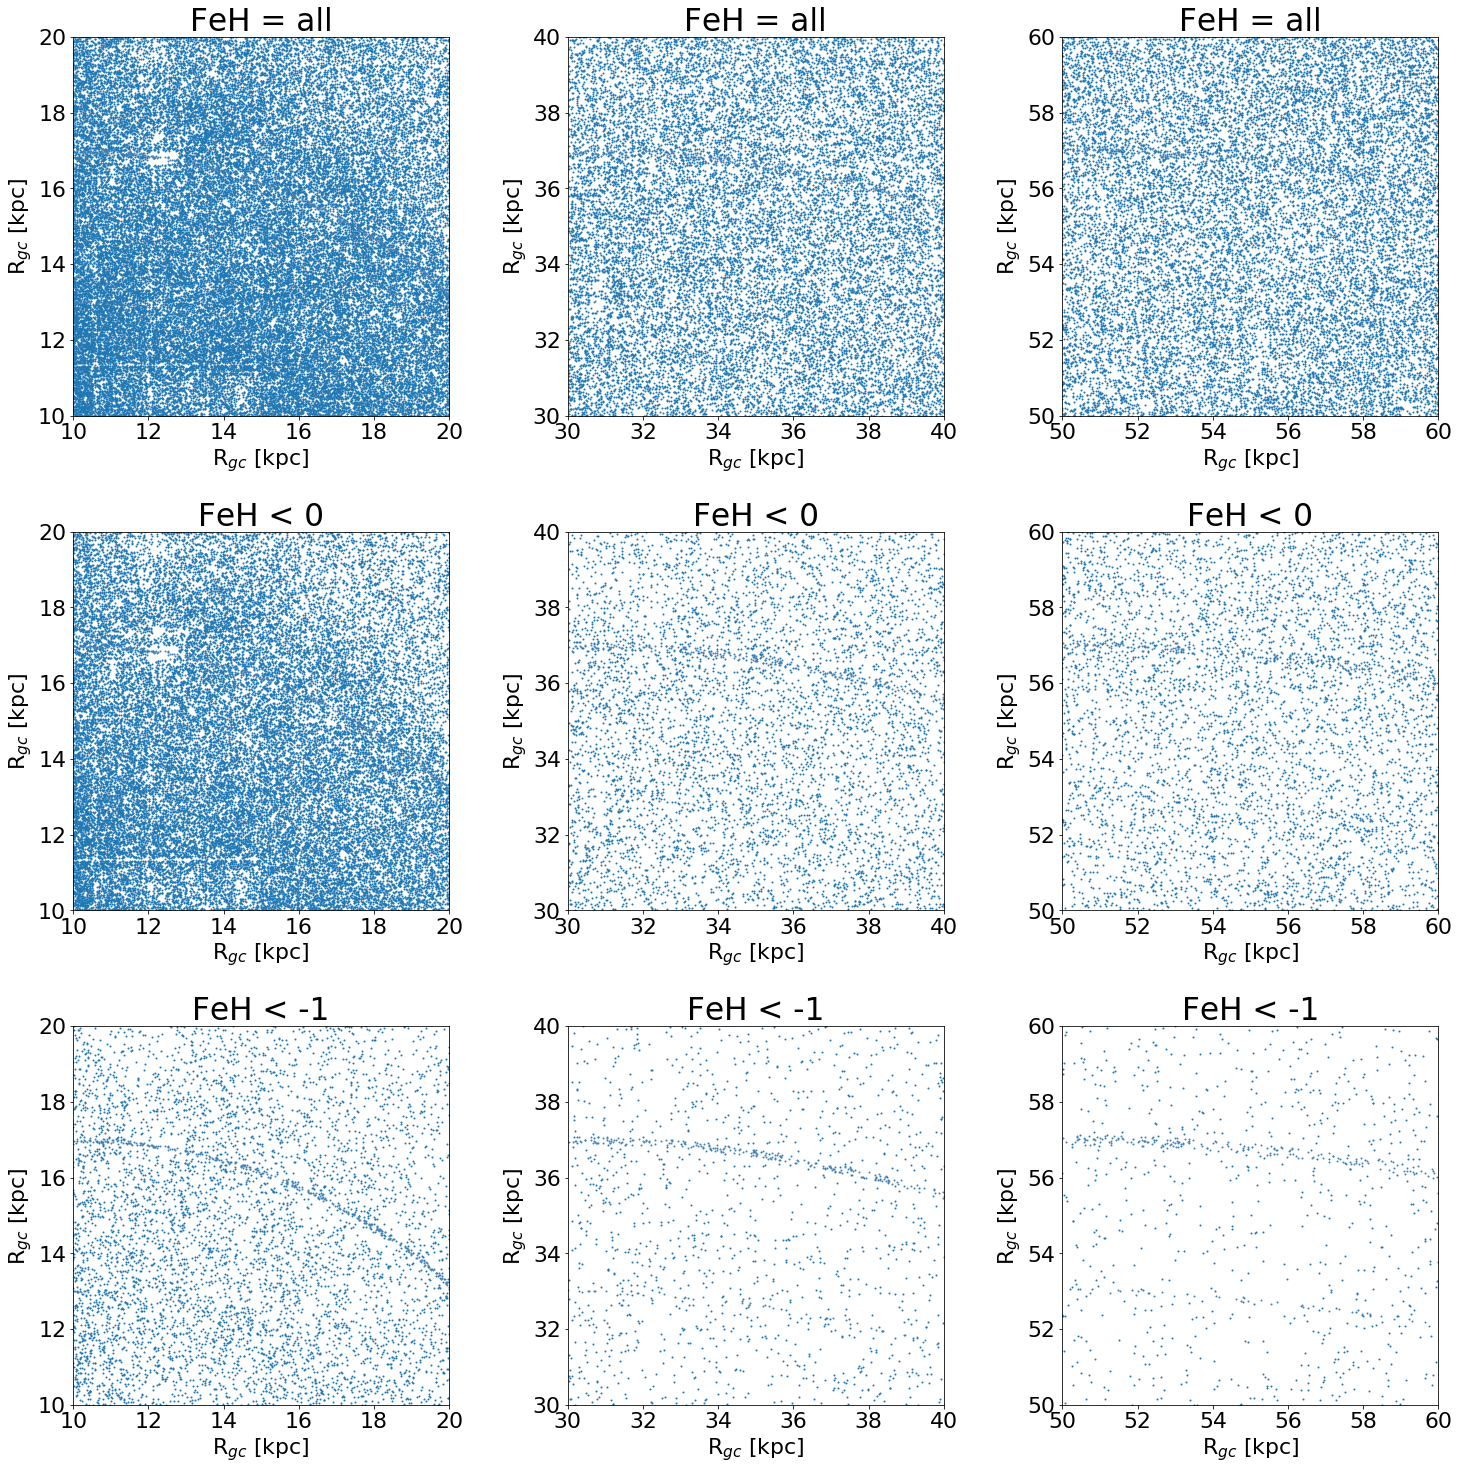

In [780]:
fig,axes = plt.subplots(3,3,figsize=(21,21))
d_conv = 770*np.pi/180
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

sh_x = 0 #kpc
sh_y = 2 #kpc : shift the smaller stream to this radius in y so streams aren't on top of each other 

#fig.suptitle("Andromeda fields", fontsize=34, y=1.03)

#fig.suptitle("FeH all < 0", fontsize=24, y=0.03)

axes[0,0].scatter(x_box10, y_box10,s = 1)
axes[0,0].scatter(pal5_x_GC15 + 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue")
axes[0,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y, s=1, color="steelblue")
axes[0,0].set_title('FeH = all')
axes[0,0].set_xlabel('R$_{gc}$ [kpc]')
axes[0,0].set_ylabel('R$_{gc}$ [kpc]')


axes[0,1].scatter(x_box30, y_box30,s = 1)
axes[0,1].scatter(pal5_x_GC35 + 30 + sh_x,pal5_y_GC35 - sh_y, s=1, color="steelblue")
axes[0,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y , s=1, color="steelblue")
axes[0,1].set_title('FeH = all')
axes[0,1].set_xlabel('R$_{gc}$ [kpc]')
axes[0,1].set_ylabel('R$_{gc}$ [kpc]')


axes[0,2].scatter(x_box50, y_box50,s = 1)
axes[0,2].scatter(pal5_x_GC55 + 50 +sh_x,pal5_y_GC55 -sh_y, s=1, color="steelblue")
axes[0,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y , s=1, color="steelblue")
axes[0,2].set_title('FeH = all')
axes[0,2].set_xlabel('R$_{gc}$ [kpc]')
axes[0,2].set_ylabel('R$_{gc}$ [kpc]')

axes[0,0].set_xlim([10,20])
axes[0,0].set_ylim([10,20])
axes[0,1].set_xlim([30,40])
axes[0,1].set_ylim([30,40])
axes[0,2].set_xlim([50,60])
axes[0,2].set_ylim([50,60])

axes[1,0].scatter(x_box10[index_FeH0_10], y_box10[index_FeH0_10],s = 1)
axes[1,0].scatter(pal5_x_GC15+ 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue")
axes[1,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y, s=1, color="steelblue")
axes[1,0].set_title('FeH < 0')
axes[1,0].set_xlabel('R$_{gc}$ [kpc]')
axes[1,0].set_ylabel('R$_{gc}$ [kpc]')


axes[1,1].scatter(x_box30[index_FeH0_30], y_box30[index_FeH0_30],s = 1)
axes[1,1].scatter(pal5_x_GC35 + 30 + sh_x, pal5_y_GC35 - sh_y, s=1, color="steelblue")
axes[1,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y, s=1, color="steelblue")
axes[1,1].set_title('FeH < 0')
axes[1,1].set_xlabel('R$_{gc}$ [kpc]')
axes[1,1].set_ylabel('R$_{gc}$ [kpc]')


axes[1,2].scatter(x_box50[index_FeH0_50], y_box50[index_FeH0_50],s = 1)
axes[1,2].scatter(pal5_x_GC55 + 50 + sh_x,pal5_y_GC55 - sh_y, s=1, color="steelblue")
axes[1,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y, s=1, color="steelblue")
axes[1,2].set_title('FeH < 0')
axes[1,2].set_xlabel('R$_{gc}$ [kpc]')
axes[1,2].set_ylabel('R$_{gc}$ [kpc]')

axes[1,0].set_xlim([10,20])
axes[1,0].set_ylim([10,20])
axes[1,1].set_xlim([30,40])
axes[1,1].set_ylim([30,40])
axes[1,2].set_xlim([50,60])
axes[1,2].set_ylim([50,60])

axes[2,0].scatter(x_box10[index_FeH1_10], y_box10[index_FeH1_10],s = 1)
axes[2,0].scatter(pal5_x_GC15+ 10 + sh_x,pal5_y_GC15 - sh_y, s=1, color="steelblue")
axes[2,0].scatter(pal5_x_m10_GC15 + 10 - sh_x,pal5_y_m10_GC15 + sh_y, s=1, color="steelblue")
axes[2,0].set_title('FeH < -1')
axes[2,0].set_xlabel('R$_{gc}$ [kpc]')
axes[2,0].set_ylabel('R$_{gc}$ [kpc]')


axes[2,1].scatter(x_box30[index_FeH1_30], y_box30[index_FeH1_30],s = 1)
axes[2,1].scatter(pal5_x_GC35 + 30 + sh_x, pal5_y_GC35 - sh_y, s=1, color="steelblue")
axes[2,1].scatter(pal5_x_m10_GC35 + 30 - sh_x,pal5_y_m10_GC35 + sh_y, s=1, color="steelblue")
axes[2,1].set_title('FeH < -1')
axes[2,1].set_xlabel('R$_{gc}$ [kpc]')
axes[2,1].set_ylabel('R$_{gc}$ [kpc]')


axes[2,2].scatter(x_box50[index_FeH1_50], y_box50[index_FeH1_50],s = 1)
axes[2,2].scatter(pal5_x_GC55 + 50 + sh_x,pal5_y_GC55 - sh_y, s=1, color="steelblue")
axes[2,2].scatter(pal5_x_m10_GC55 + 50 - sh_x,pal5_y_m10_GC55 + sh_y, s=1, color="steelblue")
axes[2,2].set_title('FeH < -1')
axes[2,2].set_xlabel('R$_{gc}$ [kpc]')
axes[2,2].set_ylabel('R$_{gc}$ [kpc]')

axes[2,0].set_xlim([10,20])
axes[2,0].set_ylim([10,20])
axes[2,1].set_xlim([30,40])
axes[2,1].set_ylim([30,40])
axes[2,2].set_xlim([50,60])
axes[2,2].set_ylim([50,60])

fig.tight_layout()
#fig.savefig('Fig2_M31_Pandas_mag255.pdf' ,rasterized=True)


## Calculate background sqrt(N) for various areas of streams

In [781]:
#nstars_pandas_m10


In [782]:
### For various boxes calculate the background per kpc^2 
print('###################### For Pal 5-like mass ################')
print('--------For ALL [Fe/H]-----------')
print('')

box10_area_index = np.where((x_box10 > 15) & (x_box10 < 16) \
                            & (y_box10 > 15) & (y_box10 < 16) )
N_background_box10 = len(x_box10[box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15 # same area as stream
print('For background at 15 kpc for area of Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30 > 32) & (x_box30 < 33) \
                            & (y_box30 > 32) & (y_box30 < 33) )
N_background_box30 = len(x_box30[box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50 > 52) & (x_box50 < 53) \
                            & (y_box50 > 52) & (y_box50 < 53) )
N_background_box50 = len(x_box50[box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')



print('--------For [Fe/H] < 0 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH0_10] > 15) & (x_box10[index_FeH0_10] < 16) \
                            & (y_box10[index_FeH0_10] > 15) & (y_box10[index_FeH0_10] < 16) )
N_background_box10 = len(x_box10[index_FeH0_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15 # same area as stream
print('For background at 15 kpc for area of Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH0_30] > 32) & (x_box30[index_FeH0_30] < 33) \
                            & (y_box30[index_FeH0_30] > 32) & (y_box30[index_FeH0_30] < 33) )
N_background_box30 = len(x_box30[index_FeH0_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.round(np.sqrt(N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH0_50] > 52) & (x_box50[index_FeH0_50] < 53) \
                            & (y_box50[index_FeH0_50] > 52) & (y_box50[index_FeH0_50] < 53) )
N_background_box50 = len(x_box50[index_FeH0_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')


print('--------For [Fe/H] < -1 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH1_10] > 15) & (x_box10[index_FeH1_10] < 16) \
                            & (y_box10[index_FeH1_10] > 15) & (y_box10[index_FeH1_10] < 16) )
N_background_box10 = len(x_box10[index_FeH1_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15 # same area as stream
print('For background at 15 kpc for area of Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH1_30] > 32) & (x_box30[index_FeH1_30] < 33) \
                            & (y_box30[index_FeH1_30] > 32) & (y_box30[index_FeH1_30] < 33) )
N_background_box30 = len(x_box30[index_FeH1_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH1_50] > 52) & (x_box50[index_FeH1_50] < 53) \
                            & (y_box50[index_FeH1_50] > 52) & (y_box50[index_FeH1_50] < 53) )
N_background_box50 = len(x_box50[index_FeH1_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55 # same area as stream
print('For background at 35 kpc for area of Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas/np.sqrt(N_background_samearea_box50),2)))
print('')


###################### For Pal 5-like mass ################
--------For ALL [Fe/H]-----------

Stars per kpc^2 in background at 15 kpc = 485
For background at 15 kpc for area of Pal5-like stream:
sqrt(N) = 14.164866667399309
N_stars_pal5/sqrt(N_background) = 3.32


Stars per kpc^2 in background at 35 kpc = 180
For background at 35 kpc for area of Pal5-like stream:
sqrt(N) = 13.235286001141041
N_stars_pal5/sqrt(N_background) = 3.55


Stars per kpc^2 in background at 55 kpc = 159
For background at 35 kpc for area of Pal5-like stream:
sqrt(N) = 15.590116029712544
N_stars_pal5/sqrt(N_background) = 3.01



--------For [Fe/H] < 0 -----------

Stars per kpc^2 in background at 15 kpc = 353
For background at 15 kpc for area of Pal5-like stream:
sqrt(N) = 12.084508020724716
N_stars_pal5/sqrt(N_background) = 3.89


Stars per kpc^2 in background at 35 kpc = 52
For background at 35 kpc for area of Pal5-like stream:
sqrt(N) = 7.0
N_stars_pal5/sqrt(N_background) = 6.61


Stars per kpc^2 in background

In [783]:
### For various boxes calculate the background per kpc^2 
print('###################### For 10 x Pal 5-like mass ################')
print('--------For ALL [Fe/H]-----------')
print('')

box10_area_index = np.where((x_box10 > 15) & (x_box10 < 16) \
                            & (y_box10 > 15) & (y_box10 < 16) )
N_background_box10 = len(x_box10[box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15_m10 # same area as stream
print('For background at 15 kpc for area of 10 x Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30 > 32) & (x_box30 < 33) \
                            & (y_box30 > 32) & (y_box30 < 33) )
N_background_box30 = len(x_box30[box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50 > 52) & (x_box50 < 53) \
                            & (y_box50 > 52) & (y_box50 < 53) )
N_background_box50 = len(x_box50[box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')



print('--------For [Fe/H] < 0 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH0_10] > 15) & (x_box10[index_FeH0_10] < 16) \
                            & (y_box10[index_FeH0_10] > 15) & (y_box10[index_FeH0_10] < 16) )
N_background_box10 = len(x_box10[index_FeH0_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15_m10 # same area as stream
print('For background at 15 kpc for area of 10 x Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH0_30] > 32) & (x_box30[index_FeH0_30] < 33) \
                            & (y_box30[index_FeH0_30] > 32) & (y_box30[index_FeH0_30] < 33) )
N_background_box30 = len(x_box30[index_FeH0_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.round(np.sqrt(N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH0_50] > 52) & (x_box50[index_FeH0_50] < 53) \
                            & (y_box50[index_FeH0_50] > 52) & (y_box50[index_FeH0_50] < 53) )
N_background_box50 = len(x_box50[index_FeH0_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box50),2)))
print('')
print('')
print('')


print('--------For [Fe/H] < -1 -----------')
print('')

box10_area_index = np.where((x_box10[index_FeH1_10] > 15) & (x_box10[index_FeH1_10] < 16) \
                            & (y_box10[index_FeH1_10] > 15) & (y_box10[index_FeH1_10] < 16) )
N_background_box10 = len(x_box10[index_FeH1_10][box10_area_index])
print('Stars per kpc^2 in background at 15 kpc = ' + str(N_background_box10))
N_background_samearea_box10 = N_background_box10 * A15_m10 # same area as stream
print('For background at 15 kpc for area of 10 x Pal5-like stream:' )
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box10)))) # I'm multiplying by the area the stream 
#covers because this was per kpc^2 
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box10),2)))
print('')
print('')

box30_area_index = np.where((x_box30[index_FeH1_30] > 32) & (x_box30[index_FeH1_30] < 33) \
                            & (y_box30[index_FeH1_30] > 32) & (y_box30[index_FeH1_30] < 33) )
N_background_box30 = len(x_box30[index_FeH1_30][box30_area_index])
print('Stars per kpc^2 in background at 35 kpc = ' + str((N_background_box30)))
N_background_samearea_box30 = N_background_box30 * A35_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' +str(np.sqrt((N_background_samearea_box30))))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box30),2)))
print('')
print('')

box50_area_index = np.where((x_box50[index_FeH1_50] > 52) & (x_box50[index_FeH1_50] < 53) \
                            & (y_box50[index_FeH1_50] > 52) & (y_box50[index_FeH1_50] < 53) )
N_background_box50 = len(x_box50[index_FeH1_50][box50_area_index])
print('Stars per kpc^2 in background at 55 kpc = ' + str((N_background_box50)))
N_background_samearea_box50 = N_background_box50 * A55_m10 # same area as stream
print('For background at 35 kpc for area of 10 x Pal5-like stream:')
print('sqrt(N) = ' + str(np.sqrt(N_background_samearea_box50)))
print('N_stars_pal5/sqrt(N_background) = ' +\
      str(np.round(nstars_pandas_m10/np.sqrt(N_background_samearea_box50),2)))
print('')


###################### For 10 x Pal 5-like mass ################
--------For ALL [Fe/H]-----------

Stars per kpc^2 in background at 15 kpc = 485
For background at 15 kpc for area of 10 x Pal5-like stream:
sqrt(N) = 30.625990473211637
N_stars_pal5/sqrt(N_background) = 15.35


Stars per kpc^2 in background at 35 kpc = 180
For background at 35 kpc for area of 10 x Pal5-like stream:
sqrt(N) = 28.478148811971607
N_stars_pal5/sqrt(N_background) = 16.5


Stars per kpc^2 in background at 55 kpc = 159
For background at 35 kpc for area of 10 x Pal5-like stream:
sqrt(N) = 33.55022813671496
N_stars_pal5/sqrt(N_background) = 14.01



--------For [Fe/H] < 0 -----------

Stars per kpc^2 in background at 15 kpc = 353
For background at 15 kpc for area of 10 x Pal5-like stream:
sqrt(N) = 26.128027619769732
N_stars_pal5/sqrt(N_background) = 17.99


Stars per kpc^2 in background at 35 kpc = 52
For background at 35 kpc for area of 10 x Pal5-like stream:
sqrt(N) = 15.0
N_stars_pal5/sqrt(N_background) = 30.

## Checking whether there are multiple stars per pixel

In [842]:
nstars_wfirst 
#A35

181

In [871]:
# plt.plot(dfac_m10 * d_pal5/1000 , no_stars_m10*10, label='10 x Pal 5, WFIRST Z062-band', linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

# plt.plot(dfac * d_pal5/1000 , no_stars, label='Pal 5, WFIRST Z062-band', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
# plt.yscale('log')
# plt.xlim([4500,5500])
# plt.ylim([1,10000])

In [944]:
dfac = np.linspace(1,400,1000)
dfac

array([  1.        ,   1.3993994 ,   1.7987988 ,   2.1981982 ,
         2.5975976 ,   2.996997  ,   3.3963964 ,   3.7957958 ,
         4.1951952 ,   4.59459459,   4.99399399,   5.39339339,
         5.79279279,   6.19219219,   6.59159159,   6.99099099,
         7.39039039,   7.78978979,   8.18918919,   8.58858859,
         8.98798799,   9.38738739,   9.78678679,  10.18618619,
        10.58558559,  10.98498498,  11.38438438,  11.78378378,
        12.18318318,  12.58258258,  12.98198198,  13.38138138,
        13.78078078,  14.18018018,  14.57957958,  14.97897898,
        15.37837838,  15.77777778,  16.17717718,  16.57657658,
        16.97597598,  17.37537538,  17.77477477,  18.17417417,
        18.57357357,  18.97297297,  19.37237237,  19.77177177,
        20.17117117,  20.57057057,  20.96996997,  21.36936937,
        21.76876877,  22.16816817,  22.56756757,  22.96696697,
        23.36636637,  23.76576577,  24.16516517,  24.56456456,
        24.96396396,  25.36336336,  25.76276276,  26.16

In [952]:
### First I am converting the areas into stars per arcsec^2
#d_galaxy = 5000 #kpc


A15_as = (np.sqrt(A15)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A35_as = (np.sqrt(A35)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A55_as = (np.sqrt(A55)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2

A15_m10_as = (np.sqrt(A15_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A35_m10_as = (np.sqrt(A35_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2
A55_m10_as = (np.sqrt(A55_m10)/(dfac*d_pal5/1000.) * 60 * 60 *180/np.pi)**2

#Number density per arcsec
#### the number of observed stars go down!! #####
n_stars_pix = no_stars# 70 #nstars_wfirst
n_stars_pix_m10 = no_stars_m10*10# n_stars_pix*10 # nstars_wfirst_m10

no_dens_A15 = n_stars_pix/A15_as
no_dens_A35 = n_stars_pix/A35_as
no_dens_A55 = n_stars_pix/A55_as

no_dens_A15_m10 = n_stars_pix_m10/A15_m10_as
no_dens_A35_m10 = n_stars_pix_m10/A35_m10_as
no_dens_A55_m10 = n_stars_pix_m10/A55_m10_as

pix_area_WFIRS = 0.11*0.11 #arscsec^2/pixel

In [978]:
#no_dens_A35

In [954]:
# print('Number of stars per arsec^2 at a distance of ' + str(d_galaxy) + ' kpc:')
# print('Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15,2)) + ' stars per arcsec^2')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35,2)) + ' stars per arcsec^2')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55,2)) + ' stars per arcsec^2')
# print('')
# print('10 x Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15_m10,2)) + ' stars per arcsec^2')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35_m10,2)) + ' stars per arcsec^2')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55_m10,2)) + ' stars per arcsec^2')
# print('')

# print('The pixel scale of WFIRST is 0.11", thus the pixel area is only:')
# print('Pixel area WFIRST = '+str(pix_area_WFIRS) + ' arcsec^2')
# print('Thus,')

# print('')
# print('Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('')
# print('10 x Pal 5-like stream ')
# print('At 15 kpc the no. density is = ' + str(np.round(no_dens_A15_m10/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 35 kpc the no. density is = ' + str(np.round(no_dens_A35_m10/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('At 55 kpc the no. density is = ' + str(np.round(no_dens_A55_m10/pix_area_WFIRS,2)) + ' stars per WFIRST pixel')
# print('')


In [955]:
#no_dens_A15_m10

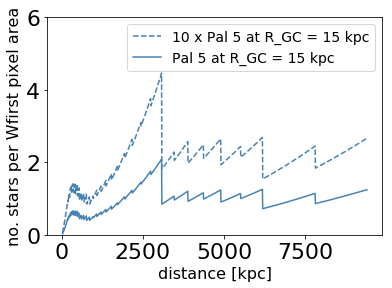

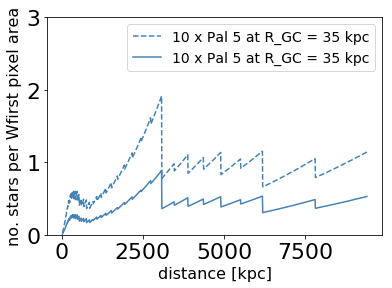

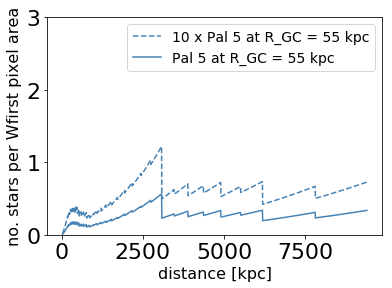

In [993]:
#### Plot this
plt.figure()
plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A15_m10/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 15 kpc', linestyle='--', color='steelblue')#,label='10 x Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A35_m10/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A55_m10/pix_area_WFIRS,  linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

plt.plot(dfac * d_pal5/1000 , no_dens_A15/pix_area_WFIRS, label='Pal 5 at R_GC = 15 kpc', linestyle='-', color='steelblue')#,label='Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS,linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A55/pix_area_WFIRS, linestyle='-', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.xlabel('distance [kpc]', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('no. stars per Wfirst pixel area', fontsize=16)
plt.ylim([0,6])
plt.savefig('Stars_per_WFIRSTpixel_RGC_15kpc.png')

plt.figure()
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A15_m10/pix_area_WFIRS, label='10 x Pal 5', linestyle='--', color='steelblue')#,label='10 x Pal 5-like')#, color='maroon', linestyle='--')
plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A35_m10/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A55_m10/pix_area_WFIRS,  linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

#plt.plot(dfac * d_pal5/1000 , no_dens_A15/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 35 kpc', linestyle='-', color='steelblue')#,label='Pal 5-like')#, color='maroon', linestyle='--')
plt.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS,linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A55/pix_area_WFIRS, linestyle='-', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.xlabel('distance [kpc]', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('no. stars per Wfirst pixel area', fontsize=16)
plt.ylim([0,3])
plt.savefig('Stars_per_WFIRSTpixel_RGC_35kpc.png')


plt.figure()
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A15_m10/pix_area_WFIRS, label='10 x Pal 5', linestyle='--', color='steelblue')#,label='10 x Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A35_m10/pix_area_WFIRS,  label='10 x Pal 5 at R_GC = 35 kpc',linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.plot(dfac_m10 * d_pal5/1000 , no_dens_A55_m10/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 55 kpc', linestyle='--', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')

#plt.plot(dfac * d_pal5/1000 , no_dens_A15/pix_area_WFIRS, label='10 x Pal 5 at R_GC = 35 kpc', linestyle='-', color='steelblue')#,label='Pal 5-like')#, color='maroon', linestyle='--')
#plt.plot(dfac * d_pal5/1000 , no_dens_A35/pix_area_WFIRS,linestyle='-', label='10 x Pal 5 at R_GC = 35 kpc', color='steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.plot(dfac * d_pal5/1000 , no_dens_A55/pix_area_WFIRS, label='Pal 5 at R_GC = 55 kpc',linestyle='-', color= 'steelblue')#,label='10 x Pal 5', color='maroon', linestyle='--')
plt.xlabel('distance [kpc]', fontsize=16)
plt.legend(fontsize=14)
plt.ylabel('no. stars per Wfirst pixel area', fontsize=16)
plt.ylim([0,3])
plt.savefig('Stars_per_WFIRSTpixel_RGC_55kpc.png')




In [963]:
#test

test = (np.sqrt(A15_m10)/1000*60*60*180/np.pi)**2
test_stars = 1000
test_stars/test/(0.11*0.11)

1.0044442009438421

## Attempt at color plot

In [784]:
###First compute color of stream stars in PANDAS
g_pandas_ind = np.where((sample_gmags + 7.6) < 25.5) #I use only stars where this is true for g, to do somehting!
i_stream_pandas = sample_imags[g_pandas_ind] + 7.6 #to move to M31
g_stream_pandas = sample_gmags[g_pandas_ind] + 7.6 #to move to M31

In [785]:
print(len(i_stream_pandas))
print(len(g_stream_pandas))

47
47


In [786]:
###TRY using isochrone from Darmouth instead
isochrone = np.genfromtxt("Isochrone.txt")
#Based on Ibata 2017 - fig 13: 11.5 Gyr, fe/H = -1.3, alpha/Fe = +0.2 , CFHT mega cam 


g_dart_ind = np.where(isochrone[:,6] + 7.6 + d_mod < 25.5)
g_dart = isochrone[:,6][g_dart_ind] + 7.6 + d_mod
i_dart = isochrone[:,8][g_dart_ind] + 7.6 + d_mod

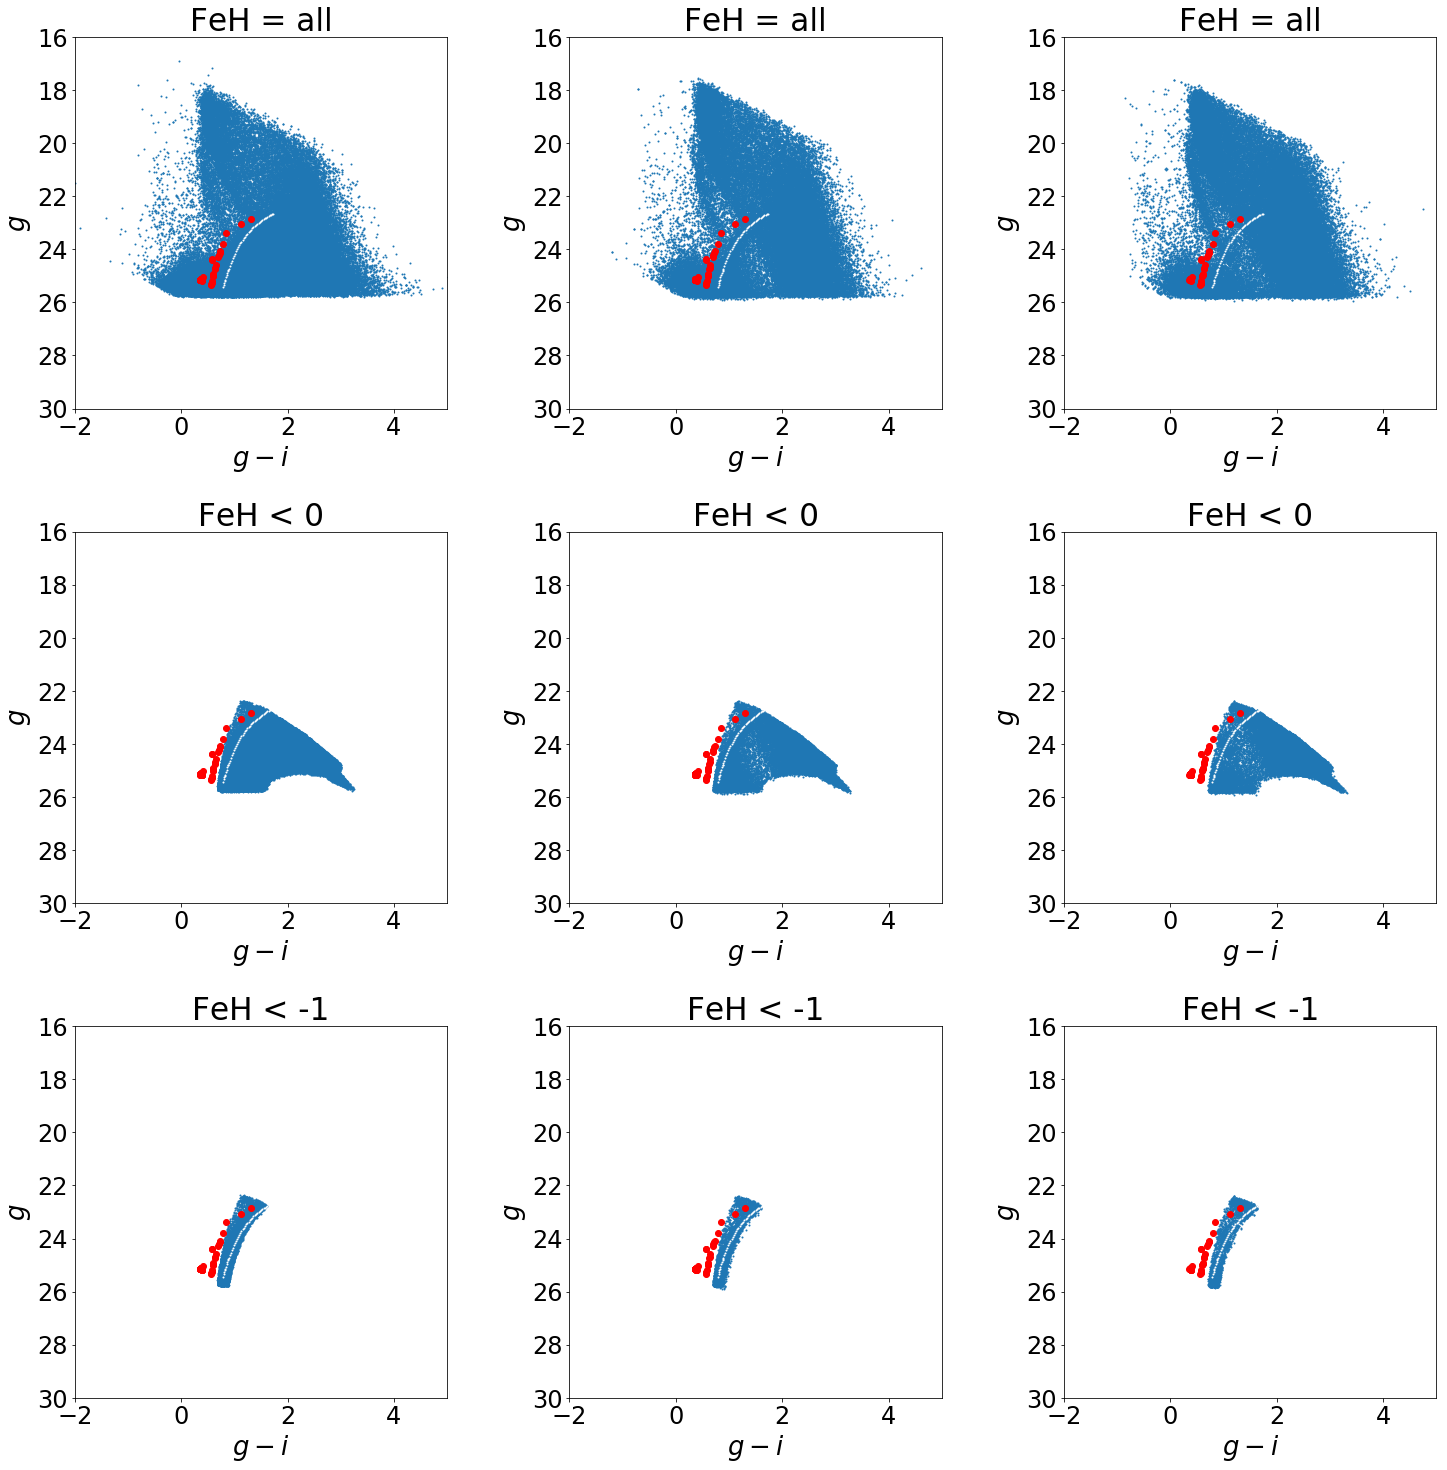

In [787]:
fig,axes = plt.subplots(3,3,figsize=(21,21))
d_conv = 770*np.pi/180
mpl.rcParams.update({'font.size': 26})
label_size = 24
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

ylim_low = 16
ylim_high = 30
xlim_low = -2
xlim_high = 5

#fig.suptitle("Andromeda fields", fontsize=34, y=1.03)

#fig.suptitle("FeH all < 0", fontsize=24, y=0.03)

axes[0,0].scatter(g_box10 - i_box10, g_box10,s = 1)
axes[0,0].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[0,0].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[0,0].set_title('FeH = all')
axes[0,0].set_xlabel('$g-i$')
axes[0,0].set_ylabel('$g$')


axes[0,1].scatter(g_box30 - i_box30, g_box30,s = 1)
axes[0,1].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[0,1].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[0,1].set_title('FeH = all')
axes[0,1].set_xlabel('$g-i$')
axes[0,1].set_ylabel('$g$')


axes[0,2].scatter(g_box50 - i_box50, g_box50,s = 1)
axes[0,2].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[0,2].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[0,2].set_title('FeH = all')
axes[0,2].set_xlabel('$g-i$')
axes[0,2].set_ylabel('$g$')

axes[0,0].set_xlim([xlim_low ,xlim_high])
axes[0,0].set_ylim([ylim_high,ylim_low])
axes[0,1].set_xlim([xlim_low ,xlim_high])
axes[0,1].set_ylim([ylim_high,ylim_low])
axes[0,2].set_xlim([xlim_low ,xlim_high])
axes[0,2].set_ylim([ylim_high,ylim_low])

axes[1,0].scatter(g_box10[index_FeH0_10] - i_box10[index_FeH0_10], g_box10[index_FeH0_10],s = 1)
axes[1,0].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[1,0].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[1,0].set_title('FeH < 0')
axes[1,0].set_xlabel('$g-i$')
axes[1,0].set_ylabel('$g$')


axes[1,1].scatter(g_box30[index_FeH0_30]-i_box30[index_FeH0_30], g_box30[index_FeH0_30],s = 1)
axes[1,1].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[1,1].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[1,1].set_title('FeH < 0')
axes[1,1].set_xlabel('$g-i$')
axes[1,1].set_ylabel('$g$')


axes[1,2].scatter(g_box50[index_FeH0_50]-i_box50[index_FeH0_50], g_box50[index_FeH0_50],s = 1)
axes[1,2].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[1,2].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[1,2].set_title('FeH < 0')
axes[1,2].set_xlabel('$g-i$')
axes[1,2].set_ylabel('$g$')

axes[1,0].set_xlim([xlim_low ,xlim_high])
axes[1,0].set_ylim([ylim_high,ylim_low])
axes[1,1].set_xlim([xlim_low ,xlim_high])
axes[1,1].set_ylim([ylim_high,ylim_low])
axes[1,2].set_xlim([xlim_low ,xlim_high])
axes[1,2].set_ylim([ylim_high,ylim_low])

axes[2,0].scatter(g_box10[index_FeH1_10]-i_box10[index_FeH1_10], g_box10[index_FeH1_10],s = 1)
axes[2,0].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[2,0].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[2,0].set_title('FeH < -1')
axes[2,0].set_xlabel('$g-i$')
axes[2,0].set_ylabel('$g$')


axes[2,1].scatter(g_box30[index_FeH1_30]-i_box30[index_FeH1_30], g_box30[index_FeH1_30],s = 1)
axes[2,1].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[2,1].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[2,1].set_title('FeH < -1')
axes[2,1].set_xlabel('$g-i$')
axes[2,1].set_ylabel('$g$')


axes[2,2].scatter(g_box50[index_FeH1_50]-i_box50[index_FeH1_50], g_box50[index_FeH1_50],s = 1)
axes[2,2].scatter(g_stream_pandas-i_stream_pandas,g_stream_pandas, color='red')
axes[2,2].scatter(g_dart - i_dart,g_dart, s = 1 , color='white')
axes[2,2].set_title('FeH < -1')
axes[2,2].set_xlabel('$g-i$')
axes[2,2].set_ylabel('$g$')

axes[2,0].set_xlim([xlim_low ,xlim_high])
axes[2,0].set_ylim([ylim_high,ylim_low])
axes[2,1].set_xlim([xlim_low ,xlim_high])
axes[2,1].set_ylim([ylim_high,ylim_low])
axes[2,2].set_xlim([xlim_low ,xlim_high])
axes[2,2].set_ylim([ylim_high,ylim_low])
fig.tight_layout()
fig.savefig('CMD_pandas_Dartmouth.png' )




## Integrated light plot

In [788]:

pal5_width = 0.058 #kpc #I checked that this gets a length of ~20 deg at for 8 kpc long stream
pal5_length = 8.5 #kpc
d = np.arange(0,100,1) #distance in kpc
d_large = np.logspace(1, 9, num=50, endpoint=True, base=10.0, dtype=None) #base 10 so from 10 to 10^5
w = pal5_width/d * 180/np.pi  #radians to degree

w_arcsec = pal5_width/d_large * 60*60 *180/np.pi
distance = np.arange(0,10,0.1)
Pal5_width = np.logspace(100,0,100)
Pal5_x10_width =np.logspace(50,0,100)


pal5_width_m10 = np.array([w_15,w_35,w_55])*m_corr #[pc] for pal 5 at 15,35,55 kpc
w_arcsec_m10 = np.zeros([len(pal5_width_m10),len(d_large)])
for i in range(len(w_arcsec_m10)):
    w_arcsec_m10[i,:] = pal5_width_m10[i]/d_large * 60 * 60 *180/np.pi

    
    
pal5_width = np.array([w_15,w_35,w_55]) #[pc] for pal 5 at 15,35,55 kpc
w_arcsec = np.zeros([len(pal5_width),len(d_large)])
for i in range(len(w_arcsec)):
    w_arcsec[i,:] = pal5_width[i]/d_large * 60*60 *180/np.pi

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  


In [789]:
w_arcsec_m10.shape

(3, 50)

/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_base.py:3129: UserWarning: Attempted to set non-positive xlimits for log-scale axis; invalid limits will be ignored.
  'Attempted to set non-positive xlimits for log-scale axis; '


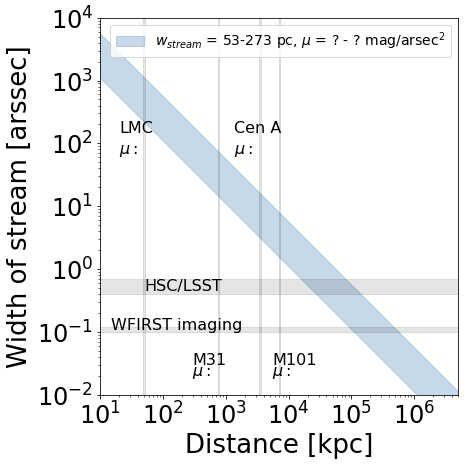

In [790]:
fig,axes = plt.subplots(1,1,figsize=(7,7))

mpl.rcParams.update({'font.size': 24})
label_size = 22
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18


#axes.plot(d_large/1000, 2.25*w_arcsec, color='maroon', linestyle='-', label='10 x Pal 5 like stream')
#axes.plot(d_large/1000,w_arcsec, color='maroon', linestyle='--', label='Pal 5 like stream')
#axes.plot(d_large, w_arcsec_m10[2,:].T, color='blue', linestyle='--', alpha=1)#,  label='R$_{GC}$: 55 kpc, $\mu$ = mag/arsec$^2$'
#axes.plot(d_large, w_arcsec_m10[1,:].T, color='steelblue', linestyle='-', linewidth=12, alpha=0.2)# label='R$_{GC}$: 35 kpc, $\mu$ = mag/arsec$^2$'
#axes[0].plot(d_large, w_arcsec_m10[0,:].T, color='steelblue', linestyle='--', label='R$_{GC}$: 15 kpc, $\mu$ = mag/arsec$^2$', alpha=0.3)

#axes[0].plot(d_large,w_arcsec[2,:].T, color='blue', linestyle='-', label='R$_{GC}$: 55 kpc, $\mu$ = mag/arsec$^2$', alpha=1)
#axes.plot(d_large,w_arcsec[1,:].T, color='steelblue', linestyle='-', linewidth=7.8, alpha=0.2)#label='R$_{GC}$: 35 kpc, $\mu$ = mag/arsec$^2$',)
#axes[0].plot(d_large,w_arcsec[0,:].T, color='blue', linestyle='-', label='R$_{GC}$: 15 kpc, $\mu$ = mag/arsec$^2$', alpha=0.3)
#axes.plot(d_large,w_arcsec[0,:].T, color='blue', linestyle='-',  alpha=1)#,label='R$_{GC}$: 15 kpc, $\mu$ = mag/arsec$^2$'


axes.fill_between(d_large, w_arcsec_m10[2,:].T,w_arcsec[0,:].T, color='steelblue', alpha=0.3, label = '$w_{stream}$ = 53-273 pc, $\mu$ = ? - ? mag/arsec$^2$')


#axes.plot(distance ,Pal5_x10_width ,label='10 x Pal 5-like stream', color='maroon', linestyle='--')
#axes.plot(distance ,Pal5_width ,label='Pal 5-like stream', color = 'maroon')
#axes.legend(fontsize=12, loc="upper right")
axes.legend(fontsize=14, loc="upper right")


#axes.set_title('FeH = all, R$_{gc}$ = 10kpc')
axes.set_xlabel('Distance [Mpc]')
#axes.fill_between([0.740,0.80],0,2200,color='steelblue', alpha=0.3)
#axes.text(0.95,100, 'M31', fontsize=16)
#axes.text(5*10**6, 10**2, 'm=m$_{Pal 5}$', fontsize=16,color='steelblue')
axes.fill_between([0,10000000000],0.4,0.7,color='black', alpha=0.1)
axes.text(5*10, 0.45, 'HSC/LSST', fontsize=16,color='black')
#axes.fill_between([0,100000000],0.65,0.75,color='black', alpha=0.1) #https://arxiv.org/pdf/0805.2366.pdf, Fig 21, 0.7
#axes.text(100, 0.22, 'LSST', fontsize=16,color='black')
axes.fill_between([0,10000000000],0.10,0.12,color='black', alpha=0.1) #Spergel 2013: pixel scale is 0.11 arcsec
axes.text(15, 0.11, 'WFIRST imaging', fontsize=16,color='black')

axes.set_xlabel('Distance [kpc]')
axes.fill_between([48,51],0,1000000,color='black', alpha=0.1)
axes.text(20,1.5*10**2, 'LMC', fontsize=16,color='black')
axes.text(20,7*10, '$\mu:$', fontsize=16,color='black')
axes.fill_between([755,785],0,1000000,color='black', alpha=0.1)
axes.text(290,0.03, 'M31', fontsize=16,color='black')
axes.text(290,0.02, '$\mu:$', fontsize=16,color='black')
axes.fill_between([3400,3600],0,1000000,color='black', alpha=0.1)
axes.text(1350, 1.5*10**2, 'Cen A', fontsize=16,color='black')
axes.text(1350, 7*10, '$\mu:$', fontsize=16,color='black')
axes.fill_between([7000,7360],0,1000000,color='black', alpha=0.1)
axes.text(5450, 0.03, 'M101', fontsize=16,color='black')
axes.text(5450, 0.02, '$\mu:$', fontsize=16,color='black')
axes.set_ylabel('Width of stream [arssec]')
axes.set_yscale('log')
axes.set_xscale('log')
#axes.set_title('given some kind of limiting magnitude', fontsize=14)
axes.set_xlim([0,5000000])
axes.set_ylim([0.01,10020])
axes.set_xticks([10,10**2,10**3,10**4,10**5,10**6])
#axes.legend(fontsize=14)
axes.set_aspect('equal')






# #axes.set_title('FeH = all, R$_{gc}$ = 10kpc')
# axes[1].set_xlabel('Distance [Mpc]')
# #axes.fill_between([0.740,0.80],0,2200,color='steelblue', alpha=0.3)
# #axes.text(0.95,100, 'M31', fontsize=16)
# axes[1].text(5*10**6, 10**2, 'm=10xm$_{Pal 5}$', fontsize=16,color='steelblue')
# axes[1].fill_between([0,10000000000],0.4,0.7,color='black', alpha=0.1)
# axes[1].text(5*10**6, 0.40, 'HSC/LSST', fontsize=16,color='black')
# #axes.fill_between([0,100000000],0.65,0.75,color='black', alpha=0.1) #https://arxiv.org/pdf/0805.2366.pdf, Fig 21, 0.7
# #axes.text(100, 0.22, 'LSST', fontsize=16,color='black')
# axes[1].fill_between([0,10000000000],0.12,0.14,color='black', alpha=0.1) #Spergel 2013: pixel scale is 0.11 arcsec
# axes[1].text(10**6, 0.09, 'WFIRST imaging', fontsize=16,color='black')

# axes[1].set_xlabel('Distance [kpc]')
# axes[1].fill_between([48,51],0,1000000,color='black', alpha=0.1)
# axes[1].text(20,10**4, 'LMC', fontsize=16,color='black')
# axes[1].text(20,5*10**3, '$\mu:$', fontsize=16,color='black')
# axes[1].fill_between([755,785],0,1000000,color='black', alpha=0.1)
# axes[1].text(290,0.0005, 'M31', fontsize=16,color='black')
# axes[1].text(290,0.0002, '$\mu:$', fontsize=16,color='black')
# axes[1].fill_between([3400,3600],0,1000000,color='black', alpha=0.1)
# axes[1].text(1350, 10**4, 'Cen A', fontsize=16,color='black')
# axes[1].text(1350, 5*10**3, '$\mu:$', fontsize=16,color='black')
# axes[1].fill_between([7000,7360],0,1000000,color='black', alpha=0.1)
# axes[1].text(5450, 0.0005, 'M101', fontsize=16,color='black')
# axes[1].text(5450, 0.0002, '$\mu:$', fontsize=16,color='black')
# axes[1].set_ylabel('Width of stream [arssec]')
# axes[1].set_yscale('log')
# axes[1].set_xscale('log')
# #axes.set_title('given some kind of limiting magnitude', fontsize=14)
# axes[1].set_xlim([0,5000000000])
# axes[1].set_ylim([0.0001,100020])
# #axes.legend(fontsize=14)
# axes[1].set_aspect('equal')





fig.tight_layout()
fig.savefig('Fig5_integrated.pdf',  rasterized=True)